In [1]:
from qutip import *

import numpy as np
from numpy import pi as pi
from numpy import exp as exp
from numpy import sqrt as sqrt

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,10)

from scipy.optimize import curve_fit as cf

In [2]:
def boltzmann(gs, T):
    return np.exp(-6.26e-34*gs*1e9/(1.38e-23*T))

def sigmoid(t, risetime, t0):
    a = risetime/(2*4.4)
    return 1/(np.exp(-(t-t0)/a)+1)

def pulse_sig(t, t0, width, risetime=1):
    return np.where(t<width/2+t0, sigmoid(t,risetime,t0),1-sigmoid(t,risetime,t0+width)).astype(float)

def pulse_rect(t, t0, width):
    return np.where( (t0<t) & (t<(width+t0)), 1.0, 0.0).astype(float)

def seqC3(t, args): 
    tstart = args['tstart']
    pulsewidth = args['pulsewidth']
    return np.where(t<pulsewidth/2+tstart, sigmoid(t,0.86,4+tstart),1-sigmoid(t,0.86,pulsewidth+2+tstart))

In [3]:
g1 = basis(6,0)
g2 = basis(6,1)
m1 = basis(6,2)
m2 = basis(6,3)
e1 = basis(6,4)
e2 = basis(6,5)

In [31]:
gs = 600
T = 5
eta_spin = 2
eta_cd = 2

T1_opt = 1.7
T1_orb = (46/gs)**3 * 40
T1_spin = 400

Gamma1_opt = 1/(2*pi*T1_opt)
Gamma1_spin = 1/(2*pi*T1_spin)
Gamma1_orb = 1/(1+boltzmann(gs,T))*1/(2*pi*T1_orb)
Gamma1_orb_em = Gamma1_orb
Gamma1_orb_abs = boltzmann(gs, T) * Gamma1_orb_em
c_ops = [
sqrt(Gamma1_opt)*(g1 + 1/eta_spin*g2 + 1/eta_cd*(1/eta_spin*m1 + m2))*e2.dag(),
sqrt(Gamma1_opt)*(g1 + 1/eta_spin*g2 + 1/eta_cd*(m1 + 1/eta_spin*m2))*e1.dag(),
(sqrt(Gamma1_orb_em) * g1 + sqrt(Gamma1_spin)*m2)*m1.dag(),
(sqrt(Gamma1_orb_em) * g2 + sqrt(Gamma1_spin)*m1)*m2.dag(),
(sqrt(Gamma1_orb_abs) * m1 + sqrt(Gamma1_spin)*g2)*g1.dag(),
(sqrt(Gamma1_orb_abs) * m2 + sqrt(Gamma1_spin)*g1)*g2.dag()
]
rho0 = steadystate(Qobj(np.zeros((6,6))), c_ops)
rho0

Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[4.97847102e-01 6.24011834e-17 5.42948511e-19 4.67393803e-04
  0.00000000e+00 0.00000000e+00]
 [6.24011834e-17 4.97847102e-01 4.67393803e-04 1.35737128e-19
  0.00000000e+00 0.00000000e+00]
 [5.42948511e-19 4.67393803e-04 2.15289779e-03 6.81651139e-20
  0.00000000e+00 0.00000000e+00]
 [4.67393803e-04 1.35737128e-19 6.81651139e-20 2.15289779e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  5.12114381e-17 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]

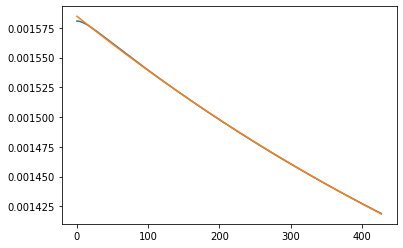

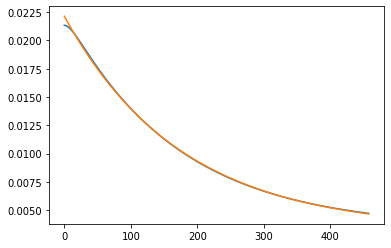

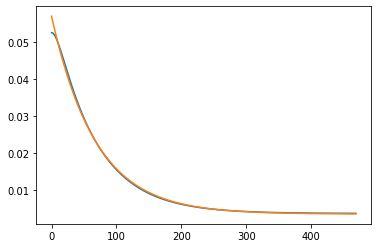

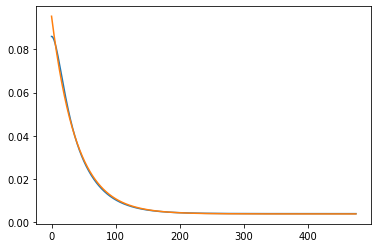

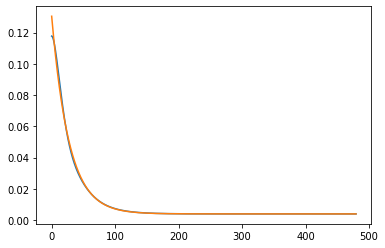

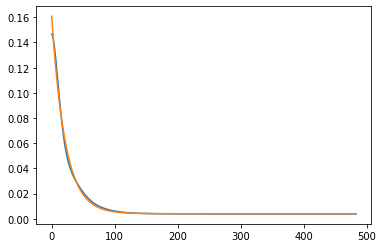

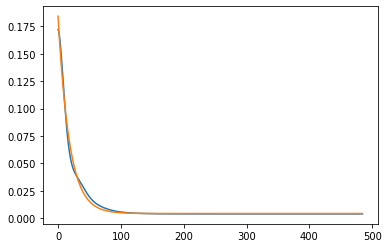

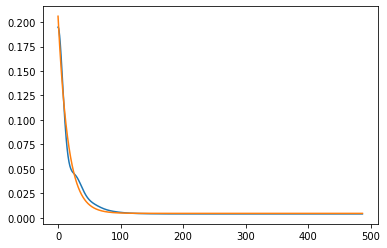

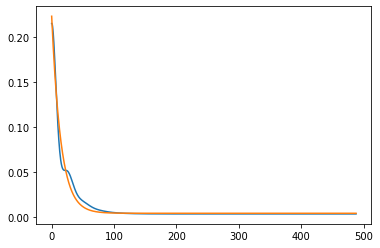

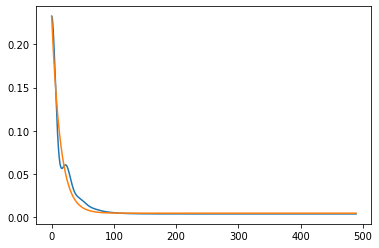

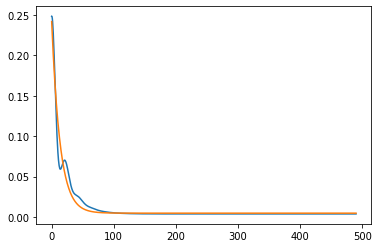

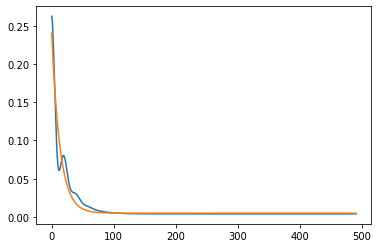

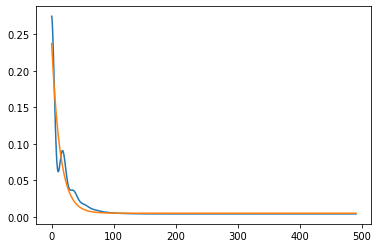

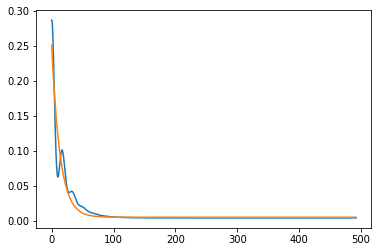

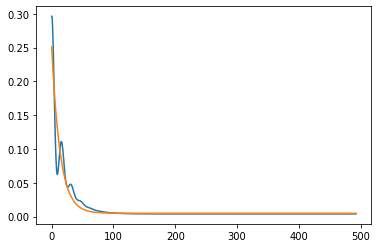

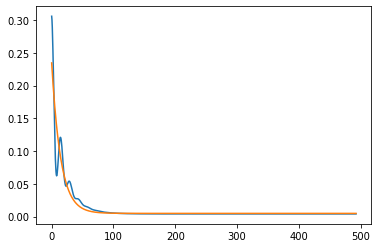

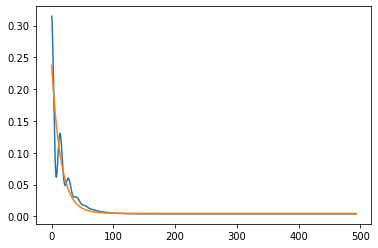

In [32]:
ts= np.arange(0, 500, 0.5)
Omegas = np.arange(0.1, 5, 0.3) * Gamma1_opt
init_pop = np.zeros((len(Omegas), len(ts)))
Gamma_init = np.zeros_like(Omegas)
for i, Omega in enumerate(Omegas):
    Hinit = Omega/2 * (g2*e2.dag() + e2*g2.dag())
    e_ops = [e1*e1.dag(), e2*e2.dag()]
    exps = mesolve(Hinit, rho0, ts, e_ops=e_ops, c_ops=c_ops).expect
    pop = exps[0] + exps[1]
    init_pop[i]  = pop
    plt.plot(ts[np.argmax(pop):]-ts[np.argmax(pop)], init_pop[i][np.argmax(pop):])
    exp_decay = lambda x, A, Gamma, c: A*np.exp(-Gamma*x) + c    
    x, y = ts[np.argmax(pop):]-ts[np.argmax(pop)], init_pop[i][np.argmax(pop):]
    popt, pcov = cf(exp_decay, 
                    x, y, 
                    p0=(np.amax(y), 1/100, np.amin(y)))
    Gamma_init[i] = popt[1]
    plt.plot(x, exp_decay(x, *popt))
    plt.show()

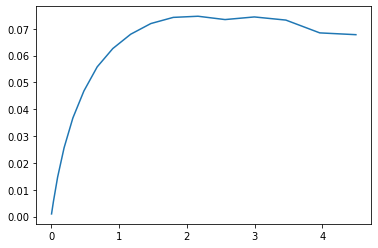

In [33]:
plt.plot(2*Omegas**2/Gamma1_opt, Gamma_init)

In [ ]:
fig, axs = plt.subplots(4,1)
axs[0].plot(t, reset_seq, '-k')
axs[0].plot(t, raman_seq, '-b')
axs[0].plot(t, init_seq, '-r')
axs[1].plot(t, exps[0], '-r', label='g1')
axs[1].plot(t, exps[1], '-b', label='g2')
axs[1].legend()
axs[2].plot(t, exps[2], '-y', label='m1')
axs[2].plot(t, exps[3], '-g', label='m2')
axs[2].legend()
axs[3].plot(t, (exps[4] + exps[5]), '-k')
plt.tight_layout()